In [194]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid


In [195]:
root = './flowers'
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])
data = datasets.ImageFolder(root = root, transform=transform)
data

Dataset ImageFolder
    Number of datapoints: 4323
    Root Location: ./flowers
    Transforms (if any): Compose(
                             Resize(size=224, interpolation=PIL.Image.BILINEAR)
                             CenterCrop(size=(224, 224))
                             ToTensor()
                             Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                         )
    Target Transforms (if any): None

In [196]:
classes = data.classes
classes

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [197]:

trainset_len = int(0.8*len(data))
testset_len = int(len(data) - trainset_len)
train_data, test_data = random_split(data, lengths=[trainset_len, testset_len])

In [198]:
a = []
for images, label in train_data:
    a.append(list(images.shape))


In [199]:
df = pd.DataFrame(a)
df.describe()
    

,0,1,2
count,3458.0,3458.0,3458.0
mean,3.0,224.0,224.0
std,0.0,0.0,0.0
min,3.0,224.0,224.0
25%,3.0,224.0,224.0
50%,3.0,224.0,224.0
75%,3.0,224.0,224.0
max,3.0,224.0,224.0


In [200]:
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=True)

['sunflower', 'rose', 'daisy', 'dandelion', 'dandelion', 'daisy', 'dandelion', 'dandelion', 'tulip', 'dandelion']


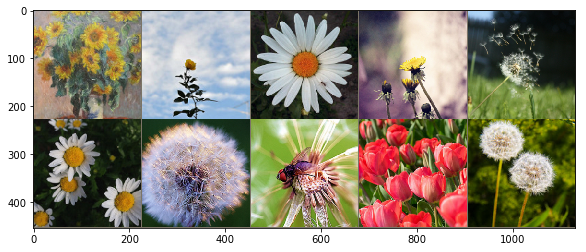

In [201]:
denormalize_data =transforms.Normalize([-0.485/0.229, -0.456/0.224, -0.406/0.225], [1/0.229, 1/0.224, 1/0.225])
for images, labels in train_loader:
    break   
im = make_grid(images, nrow=5) 
images = denormalize_data(im)
plt.figure(figsize=(10,4))
print([ classes[each] for each in labels])
plt.imshow(np.transpose( images.numpy(), (1,2,0)));

In [202]:
AlexNetModel = models.alexnet(pretrained=True)
AlexNetModel

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p

In [203]:
for param in AlexNetModel.parameters():
    param.requires_grad = False

In [204]:
AlexNetModel.classifier = nn.Sequential(
    nn.Linear(in_features=9216, out_features=1024),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(1024, 5),
    nn.LogSoftmax(dim=1)
)
AlexNetModel

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5)
    (3): Linear(in_featur

In [205]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(AlexNetModel.parameters(), lr=0.001)

In [218]:
import time
start_time = time.time()
epochs = 2

train_corr = []
test_corr = []
train_losses = []
test_losses = []

for e in range(epochs):
    trn_cor = 0
    tst_cor = 0
    e+=1
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        y_pred = AlexNetModel(X_train)
        loss = criterion(y_pred, y_train)
        pred = torch.max(y_pred, 1)[1]
        corr = (pred == y_train).sum()
        trn_cor+=corr

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if b%100 == 0:
            print(f'epoc: {e:2}  batch: {b:4} [{10*b:6}/{len(train_data)}]  loss: {loss.item():10.8f}  accuracy: {trn_cor.item()*100/(10*b):7.3f}%')   
    train_losses.append(loss)    
    train_corr.append(trn_cor)
    for b, (X_test, y_test) in enumerate(test_loader):
        y_pred = AlexNetModel(X_test)
        pred = torch.max(y_pred, 1)[1]
        corr = (pred == y_test).sum()
        tst_cor+=corr
    loss = criterion(y_pred, y_test)    
    test_losses.append(loss)    
    test_corr.append(tst_cor)   
    print(f'epoc: {e:2}  batch: TEST                 loss: {loss.item():10.8f}  accuracy: {tst_cor.item()*100/len(test_data):7.3f}%')
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

epoc:  1  batch:  100 [  1000/3458]  loss: 0.24569328  accuracy:  98.000%
epoc:  1  batch:  200 [  2000/3458]  loss: 0.00095687  accuracy:  97.850%
epoc:  1  batch:  300 [  3000/3458]  loss: 0.08680086  accuracy:  97.700%
epoc:  1  batch: TEST                 loss: 0.21249923  accuracy:  84.740%
epoc:  2  batch:  100 [  1000/3458]  loss: 0.00250980  accuracy:  99.000%
epoc:  2  batch:  200 [  2000/3458]  loss: 0.00011970  accuracy:  99.050%
epoc:  2  batch:  300 [  3000/3458]  loss: 0.01911047  accuracy:  98.367%
epoc:  2  batch: TEST                 loss: 0.00448659  accuracy:  84.624%

Duration: 282 seconds


label: tulip 


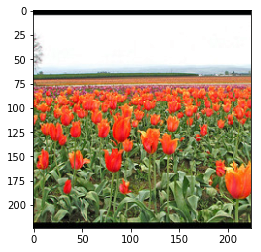

In [224]:
x = 800
im = denormalize_data(test_data[x][0])
print(f"label: {classes[test_data[x][1]]} ")
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

In [220]:
test_data[x][0].shape

torch.Size([3, 224, 224])

In [225]:
AlexNetModel.eval()
with torch.no_grad():
    pred = AlexNetModel( test_data[x][0].view(1,3,224,224)).argmax()
    print(f"prediction is {classes[pred]}" )

prediction is tulip


In [226]:
torch.save(AlexNetModel.state_dict(), 'AlexNetModelImageModel.pt')

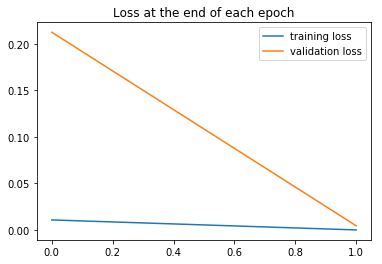

In [227]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

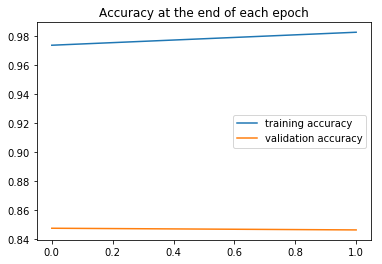

In [235]:
plt.plot([t.item()/len(train_data) for t in train_corr], label='training accuracy')
plt.plot([t.item()/len(test_data) for t in test_corr], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();